# Model Tracking and Versioning in VerticaPy

In [3]:
import verticapy as vp
import warnings
warnings.filterwarnings('ignore')
%load_ext verticapy.sql
vp.connect('abdel_ml')

The verticapy.sql extension is already loaded. To reload it, use:
  %reload_ext verticapy.sql


In [4]:
from verticapy.datasets import load_titanic
 
titanic_vDF = load_titanic()
predictors = ["age", "fare", "pclass"]
response = "survived"
titanic_vDF[response].dropna()
# split the data into train and test sets
train_vdf, test_vdf = titanic_vDF.train_test_split()

Nothing was filtered.


## Model Tracking

`vExperiment` object will track all the model that are added to it and it can backed them up in the database if we specify the `experiment_table` parameter with a table name.

In [5]:
import verticapy.mlops.model_tracking as mt
 
my_experiment = mt.vExperiment(experiment_name = "my_exp_1",
                              test_relation = test_vdf,
                              X=predictors,
                              y=response,
                              experiment_type="binary",
                              experiment_table="my_exp_table")

In [6]:
# train a LogisticRegression model
from verticapy.learn.linear_model import LogisticRegression
model_1 = LogisticRegression("logistic_reg_m", overwrite_model=True, max_iter=2)
model_1.fit(train_vdf, predictors, response)
my_experiment.add_model(model_1)
 
# train a LinearSVC model
from verticapy.learn.svm import LinearSVC
model_2 = LinearSVC("svc_m", overwrite_model=True, max_iter=2)
model_2.fit(train_vdf, predictors, response)
my_experiment.add_model(model_2)
 
# train a DecisionTreeClassifier model
from verticapy.learn.tree import DecisionTreeClassifier
model_3 = DecisionTreeClassifier("tree_m", overwrite_model=True, max_depth=3)
model_3.fit(train_vdf, predictors, response)
my_experiment.add_model(model_3)

# train RandomForesClassiffier
from verticapy.learn.ensemble import RandomForestClassifier
model_4 = RandomForestClassifier(name = "rf_m",
                               n_estimators = 20,
                               max_features = "auto",
                               max_leaf_nodes = 32, 
                               sample = 0.7,
                               max_depth = 3,
                               min_samples_leaf = 5,
                               min_info_gain = 0.0,
                               nbins = 32)
model_4.fit(train_vdf, predictors, response)
my_experiment.add_model(model_4)

,model_name,model_type,,auc,prc_auc,accuracy,log_loss,precision,recall,f1_score,mcc,informedness,markedness,csi,user_defined_metrics
1,logistic_reg_m,LogisticRegression,,0.714187813283208,0.6506897002027295,0.6676923076923077,0.279169490471408,0.6436781609195402,0.42105263157894735,0.509090909090909,0.2882859515672943,0.25959429824561386,0.32014874915483427,0.34146341463414637,[null]
2,svc_m,LinearSVC,,0.6773770363408514,0.6155140227957557,0.6553846153846153,0.281411875843566,0.6721311475409836,0.3082706766917293,0.422680412371134,0.25701655095952053,0.20410401002506262,0.32364629905613507,0.2679738562091503,[null]
3,tree_m,RandomForestClassifier,,0.6868538533834587,0.6421917671408657,0.676923076923077,0.271126067520861,0.6272727272727273,0.518796992481203,0.5679012345679012,0.31719337808408565,0.3052553258145365,0.32959830866807627,0.39655172413793105,[null]
4,rf_m,RandomForestClassifier,,0.7256030701754383,0.6527685571602312,0.68,0.263198006055071,0.6835443037974683,0.40601503759398494,0.5094339622641509,0.3161550726353447,0.27580670426065157,0.3624060924153545,0.34177215189873417,[null]

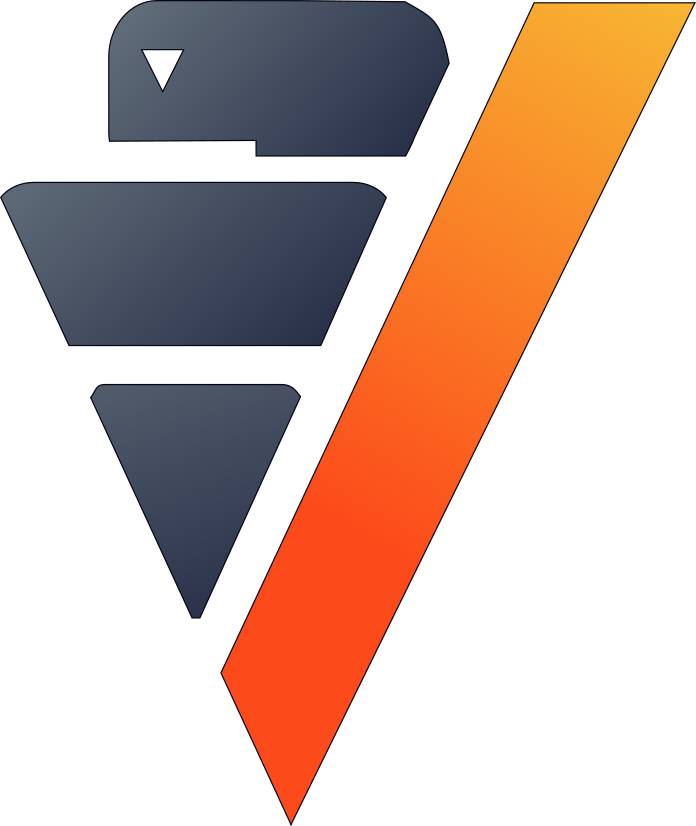

In [7]:
# list all the models 
my_experiment.list_models()

In [8]:
# load the best model based on a metric 
best_model = my_experiment.load_best_model(metric="auc")

,Abcexperiment_nameVarchar(128),Abcexperiment_typeVarchar(32),123model_idInteger,123user_idInteger,AbcVarchar(2048),AbcVarchar(2048),Abcuser_defined_metricsVarchar(2048)
1,my_exp_1,binary,45035996274546950,45035996273704962,,,None
2,my_exp_1,binary,45035996274547278,45035996273704962,,,None
3,my_exp_1,binary,45035996274547418,45035996273704962,,,None
4,my_exp_1,binary,45035996274547102,45035996273704962,,,None

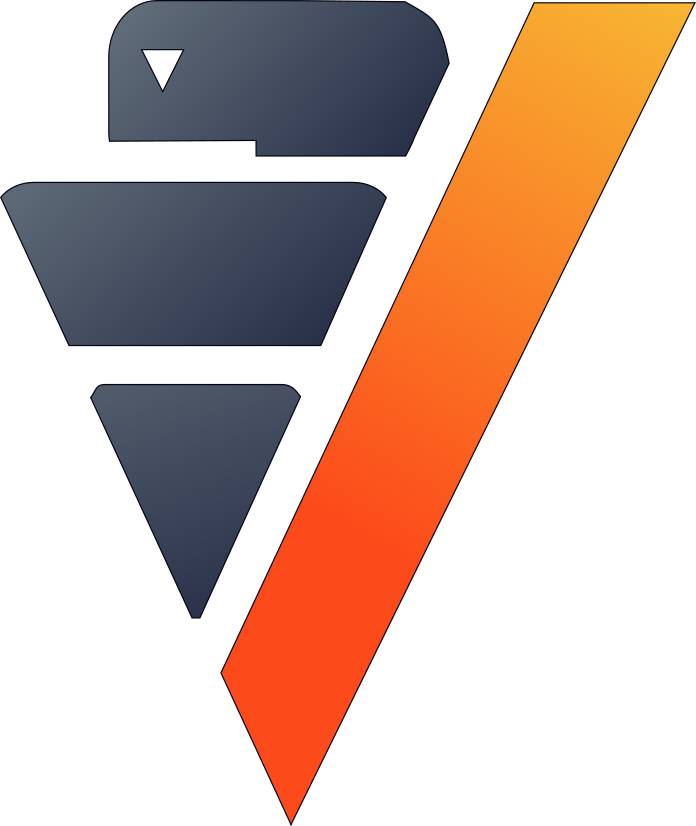

In [9]:
%%sql
select * from my_exp_table;

In [10]:
# drop my_exp_table and all the models exept the best_model
my_experiment.drop(keeping_models=[best_model.model_name])

In [11]:
# %%sql
# select * from my_exp_table;

Experiments can be used in hyper-parameter grid search. Example: comparing number of estimators's impact on RandomForestClassifier prediction performance.

In [12]:
# create an experiment
my_experiment_grid = mt.vExperiment(experiment_name = "my_exp_grid",
                              test_relation = test_vdf,
                              X=predictors,
                              y=response,
                              experiment_type="binary",
                              experiment_table='my_exp_table')
 
# train LogisticRegression models with different values of max_iter
for i in range(1, 30, 5):
    model = RandomForestClassifier(n_estimators = i)
    model.fit(train_vdf, predictors, response)
    my_experiment_grid.add_model(model)


,,model_type,,auc,prc_auc,accuracy,log_loss,precision,recall,f1_score,mcc,informedness,markedness,csi,user_defined_metrics
1,,RandomForestClassifier,,0.6759672619047619,0.5874122214857362,0.6707692307692308,2.46427570419357,0.6477272727272727,0.42857142857142855,0.5158371040723981,0.2955671103088919,0.2671130952380951,0.3270521672420408,0.3475609756097561,[null]
2,,RandomForestClassifier,,0.7027333959899754,0.6044192028123577,0.6676923076923077,0.270509315695344,0.6623376623376623,0.38345864661654133,0.48571428571428565,0.286833862530748,0.24804197994987476,0.3316925010473397,0.32075471698113206,[null]
3,,RandomForestClassifier,,0.7315358709273181,0.682012071302433,0.6953846153846154,0.257604636861269,0.717948717948718,0.42105263157894735,0.5308056872037914,0.3528317272615778,0.30646929824561386,0.4062078272604588,0.36129032258064514,[null]
4,,RandomForestClassifier,,0.7407385651629071,0.6922768501314746,0.6892307692307692,0.255010284113032,0.7,0.42105263157894735,0.5258215962441314,0.3379226676671872,0.29605263157894735,0.3857142857142857,0.35668789808917195,[null]
5,,RandomForestClassifier,,0.720061873433584,0.6718510875980638,0.6984615384615385,0.257922929391124,0.7160493827160493,0.43609022556390975,0.5420560747663551,0.3595309029256348,0.3162985588972431,0.4086723335357214,0.3717948717948718,[null]
6,,RandomForestClassifier,,0.7354323308270674,0.680927790969717,0.7015384615384616,0.256186331393947,0.7368421052631579,0.42105263157894735,0.5358851674641147,0.36810606206225444,0.3168859649122808,0.42760515747199324,0.3660130718954248,[null]

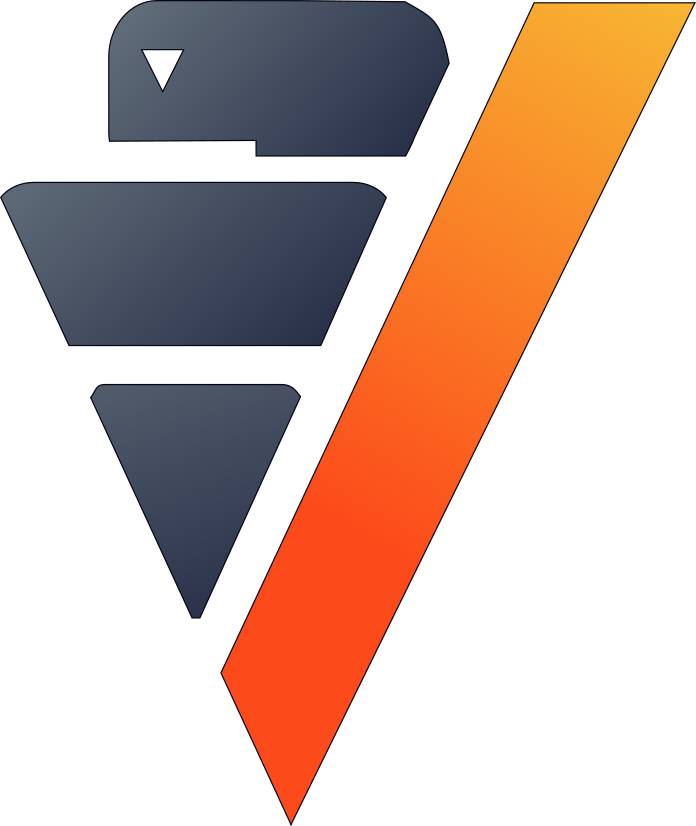

In [13]:
my_experiment_grid.list_models()

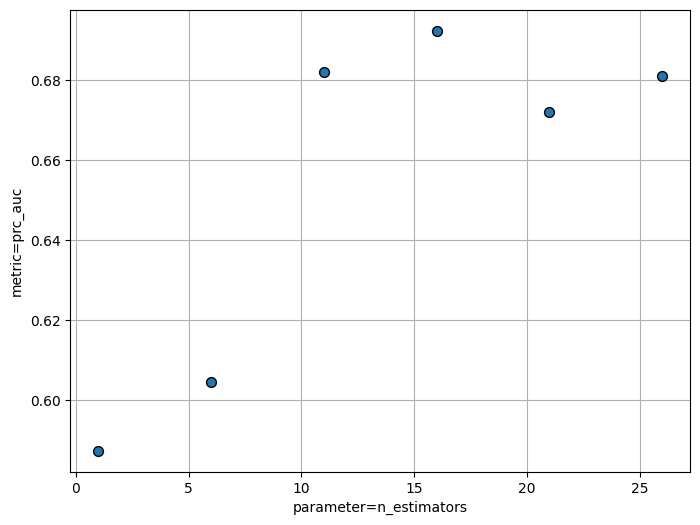

In [14]:
# plot prc_auc vs max_iter
my_experiment_grid.plot("n_estimators", "prc_auc")
 
# clean all the models associated with the experimen from the database
my_experiment_grid.drop()

## Model Versioning

Model versioning offers a framework for monitoring and controlling the status of registered models within a database.

To showcase model versioning, we will begin by registering the `best_model` picked from above experiment.

In [15]:
# register best_model
best_model.register("best_model")

True

After registration, the model owner changes to __DBADMIN__, with the previous owner having USAGE privileges. 

Registered models are identified by name and version. Only __DBADMIN__ or an __MLSUPERVISOR__ can alter their status. 

The VerticaPy library provides the `RegisteredModel` class for managing them. 

We'll use it to set our model to "production" and for scoring.

In [16]:
import verticapy.mlops.model_versioning as mv
rm = mv.RegisteredModel("best_model")

To see the list of all models registered as "best_model", use the list_models() method.

,Abcregistered_nameVarchar(128),123registered_versionInteger,AbcstatusVarchar(128),📅registered_timeTimestamptz(35),123model_idInteger,Abcschema_nameVarchar(128),Abcmodel_nameVarchar(128),Abcmodel_typeVarchar(128),AbccategoryVarchar(128)
1,best_model,2,UNDER_REVIEW,2023-10-13 10:15:12.070678-04:00,45035996274547418,public,rf_m,RF_CLASSIFIER,VERTICA_MODELS

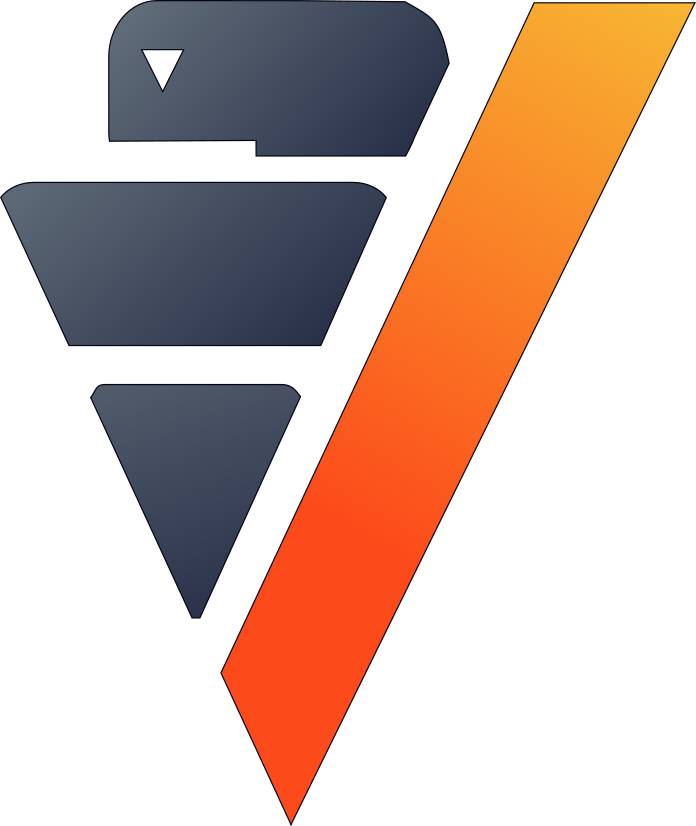

In [17]:
rm.list_models()


The recently registered model is currently in an "under_review" state. Our next action involves transitioning the model's status to "staging," intended for A/B testing. If the model performs satisfactorily during testing, we will advance it to the "production" status.

In [21]:
# change the status of the model to staging
rm.change_status(version=2, new_status="staging")
 
# change the status of the model to production
rm.change_status(version=2, new_status="production")

Only one "production" version of the registered model is allowed at a time. 

The default predict function applies to the "production" model. 

To use it on a model with a different status, you must specify the model version.

,123pclassInteger,123survivedInteger,AbcVarchar(164),AbcsexVarchar(20),123ageNumeric(8),123sibspInteger,123parchInteger,AbcticketVarchar(36),123fareNumeric(12),AbccabinVarchar(30),AbcembarkedVarchar(20),AbcboatVarchar(100),123bodyInteger,AbcVarchar(100),Abcpredicted_valueVarchar(128)
1,1,0,,male,24.0,0,1,PC 17558,247.5208,B58 B60,C,[null],[null],,1
2,1,0,,male,25.0,0,0,13905,26.0,[null],C,[null],148,,1
3,1,0,,male,42.0,0,0,110489,26.55,D22,S,[null],[null],,0
4,1,0,,male,45.0,0,0,113050,26.55,B38,S,[null],[null],,0
5,1,0,,male,46.0,1,0,W.E.P. 5734,61.175,E31,S,[null],[null],,1
6,1,0,,male,64.0,1,4,19950,263.0,C23 C25 C27,S,[null],[null],,1
7,1,0,,male,[null],0,0,113796,42.4,[null],S,[null],[null],,[null]
8,1,0,,male,32.5,0,0,113503,211.5,C132,C,[null],45,,1
9,1,0,,male,55.0,0,0,113787,30.5,C30,S,[null],[null],,0
10,1,0,,male,37.0,0,1,PC 17596,29.7,C118,C,[null],[null],,0

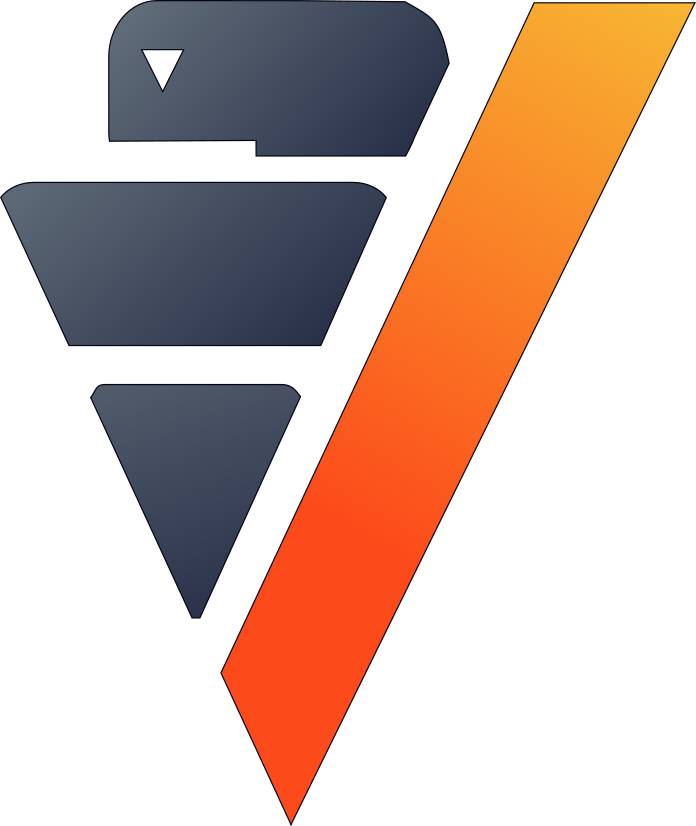

In [22]:
# prediction
rm.predict(titanic_vDF, X=predictors, name="predicted_value")

DBADMIN and users who are granted SELECT privileges on the v_monitor.model_status_history table are able to monitor the status history of registered models.

,Abcregistered_nameVarchar(128),123registered_versionInteger,Abcnew_statusVarchar(128),Abcold_statusVarchar(128),📅status_change_timeTimestamptz(35),123operator_idInteger,Abcoperator_nameVarchar(128),123model_idInteger,Abcschema_nameVarchar(128),Abcmodel_nameVarchar(128)
1,best_model,1,UNDER_REVIEW,UNREGISTERED,2023-10-13 10:01:12.834446-04:00,45035996273704962,dbadmin,45035996274539746,[null],[null]
2,best_model,1,STAGING,UNDER_REVIEW,2023-10-13 10:06:39.570543-04:00,45035996273704962,dbadmin,45035996274539746,[null],[null]
3,best_model,1,PRODUCTION,STAGING,2023-10-13 10:06:39.731503-04:00,45035996273704962,dbadmin,45035996274539746,[null],[null]
4,best_model,2,UNDER_REVIEW,UNREGISTERED,2023-10-13 10:15:12.073946-04:00,45035996273704962,dbadmin,45035996274547418,public,rf_m
5,best_model,2,STAGING,UNDER_REVIEW,2023-10-13 10:33:47.301693-04:00,45035996273704962,dbadmin,45035996274547418,public,rf_m
6,best_model,2,PRODUCTION,STAGING,2023-10-13 10:33:47.467513-04:00,45035996273704962,dbadmin,45035996274547418,public,rf_m

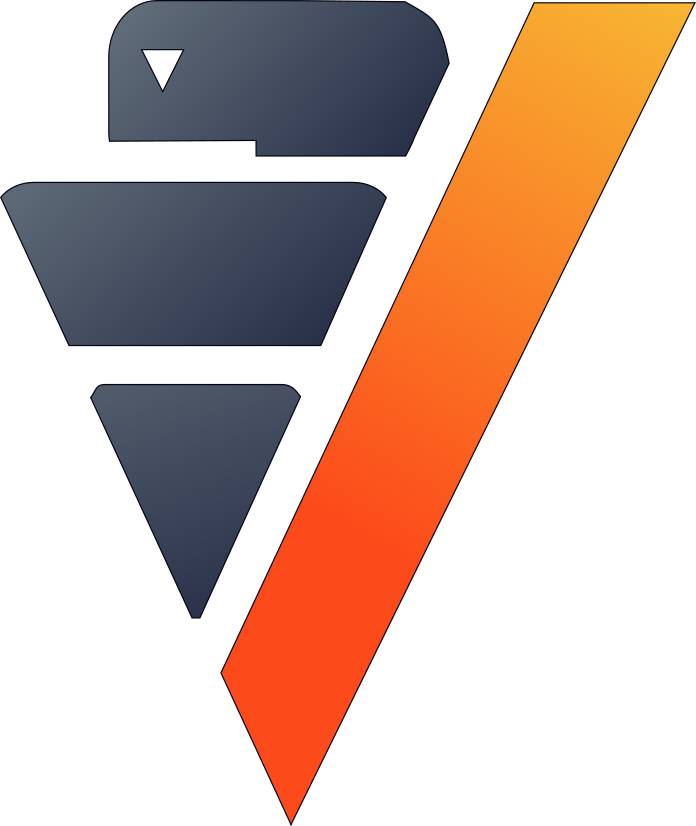

In [23]:
# check the history of the satuts of a model
rm.list_status_history()

,Abcregistered_nameVarchar(128),123registered_versionInteger,Abcnew_statusVarchar(128),Abcold_statusVarchar(128),📅status_change_timeTimestamptz(35),123operator_idInteger,Abcoperator_nameVarchar(128),123model_idInteger,Abcschema_nameVarchar(128),Abcmodel_nameVarchar(128)
1,best_model,1,UNDER_REVIEW,UNREGISTERED,2023-10-13 10:01:12.834446-04:00,45035996273704962,dbadmin,45035996274539746,[null],[null]
2,best_model,1,STAGING,UNDER_REVIEW,2023-10-13 10:06:39.570543-04:00,45035996273704962,dbadmin,45035996274539746,[null],[null]
3,best_model,1,PRODUCTION,STAGING,2023-10-13 10:06:39.731503-04:00,45035996273704962,dbadmin,45035996274539746,[null],[null]
4,best_model,2,UNDER_REVIEW,UNREGISTERED,2023-10-13 10:15:12.073946-04:00,45035996273704962,dbadmin,45035996274547418,public,rf_m
5,best_model,2,STAGING,UNDER_REVIEW,2023-10-13 10:33:47.301693-04:00,45035996273704962,dbadmin,45035996274547418,public,rf_m
6,best_model,2,PRODUCTION,STAGING,2023-10-13 10:33:47.467513-04:00,45035996273704962,dbadmin,45035996274547418,public,rf_m

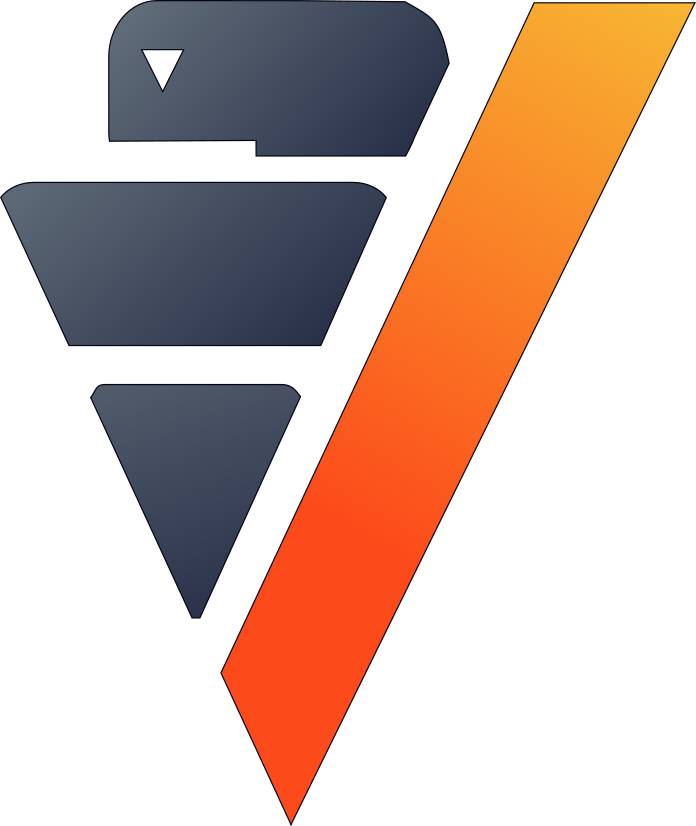

In [26]:
%%sql
select * from  v_monitor.model_status_history ;